In [1]:
import cirq_google
import numpy as np
import math
import cirq
import matplotlib.pyplot as plt
print(cirq_google.Bristlecone)

                                             (0, 5)────(0, 6)
                                             │         │
                                             │         │
                                    (1, 4)───(1, 5)────(1, 6)────(1, 7)
                                    │        │         │         │
                                    │        │         │         │
                           (2, 3)───(2, 4)───(2, 5)────(2, 6)────(2, 7)───(2, 8)
                           │        │        │         │         │        │
                           │        │        │         │         │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)────(3, 6)────(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │         │         │        │        │
                  │        │        │        │         │         │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)────(4, 6)────(4, 7)───(4, 8)───(4, 9)───(4, 10)
         │        │      

In [2]:
#Ex 1
q = cirq.LineQubit.range(4)
op = [cirq.H(q[0]),cirq.H(q[1]),cirq.Moment([cirq.CNOT(q[1],q[2]),cirq.CNOT(q[0],q[3])]),cirq.H(q[1])]
c = cirq.Circuit(op)
print(c)

          ┌──┐
0: ───H─────@────────
            │
1: ───H────@┼────H───
           ││
2: ────────X┼────────
            │
3: ─────────X────────
          └──┘


In [3]:
"""Creating a circuit from generator functions."""
def xor_swap(a, b):
    """Swaps two qubits with three CNOTs."""
    yield cirq.CNOT(a, b) # |a> |b> --> |a> |a ^ b>
    yield cirq.CNOT(b, a) # |a> |a ^ b> --> |a ^ a ^ b> | a ^ b> = |b>|a^b>
    yield cirq.CNOT(a, b) # |b> |a ^ b> --> |b>|a ^ b ^ b> = |b> |a>

print(cirq.Circuit(xor_swap(cirq.LineQubit(0), cirq.LineQubit(1))))


0: ───@───X───@───
      │   │   │
1: ───X───@───X───


In [4]:
#Ex 2
q = cirq.LineQubit.range(5)
#ops = [xor_swap(q[0],q[1]),xor_swap(q[1],q[2]),xor_swap(q[2],q[3]),xor_swap(q[3],q[4])]

def left_rotate(q, shifts):
    for s in range(shifts):
        for x in range(len(q) - 1):
            yield xor_swap(q[x],q[x + 1])

c = cirq.Circuit(left_rotate(q, 1))
print(c)

0: ───@───X───@───────────────────────────────────────
      │   │   │
1: ───X───@───X───@───X───@───────────────────────────
                  │   │   │
2: ───────────────X───@───X───@───X───@───────────────
                              │   │   │
3: ───────────────────────────X───@───X───@───X───@───
                                          │   │   │
4: ───────────────────────────────────────X───@───X───


In [5]:
#Ex 3
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
c = cirq.NamedQubit("c")

circuit = cirq.Circuit()
circuit.append([cirq.CZ(a,b), cirq.H(c), cirq.H(a)])
circuit.append([cirq.H(b),cirq.CZ(b,c),cirq.H(b)], strategy=cirq.InsertStrategy.NEW)
circuit.append([cirq.H(a),cirq.H(a)], strategy=cirq.InsertStrategy.INLINE)

print(circuit)


a: ───@───H───────────H───H───
      │
b: ───@───────H───@───H───────
                  │
c: ───H───────────@───────────


In [6]:
#Deutsch Algorithm
"""Store the operations to query each function in a dictionary."""
# Get qubits for the operations to act on.
q0, q1 = cirq.LineQubit.range(2)

# Define the dictionary of operations. The key of each dictionary entry
# is the subscript of the function f in the above explanatory text.
oracles = {
    '0': [],
    '1': [cirq.X(q1)],
    'x': [cirq.CNOT(q0, q1)],
    'notx': [cirq.CNOT(q0, q1), cirq.X(q1)]
}

"""Creating the circuit used in Deutsch's algorithm."""
def deutsch_algorithm(oracle):
    """Returns the circuit for Deutsch's algorithm given an input
    oracle, i.e., a sequence of operations to query a particular function.
    """
    yield cirq.X(q1)
    yield cirq.H(q0), cirq.H(q1)
    yield oracle
    yield cirq.H(q0)
    yield cirq.measure(q0)

for key, oracle in oracles.items():
    print(f"Circuit for f_{key}:")
    print(cirq.Circuit(deutsch_algorithm(oracle)), end="\n\n")


Circuit for f_0:
0: ───H───H───M───

1: ───X───H───────

Circuit for f_1:
0: ───H───H───M───

1: ───X───H───X───

Circuit for f_x:
0: ───H───────@───H───M───
              │
1: ───X───H───X───────────

Circuit for f_notx:
0: ───H───────@───H───M───
              │
1: ───X───H───X───X───────



In [7]:
"""Simulate each of the circuits."""
simulator = cirq.Simulator()
for key, oracle in oracles.items():
    result = simulator.run(cirq.Circuit(deutsch_algorithm(oracle)), 
                          repetitions=10)
    print('oracle: f_{:<4} results: {}'.format(key, result))


oracle: f_0    results: 0=0000000000
oracle: f_1    results: 0=0000000000
oracle: f_x    results: 0=1111111111
oracle: f_notx results: 0=1111111111


In [8]:
"""Operations to query all possible functions on two bits.
Two of these functions are constant, and six of these functions are balanced.
"""
# Define three qubits to use.
q0, q1, q2 = cirq.LineQubit.range(3)

# Define the operations to query each of the two constant functions.
constant = (
    [], 
    [cirq.X(q2)]
)

# Define the operations to query each of the six balanced functions.
balanced = (
    [cirq.CNOT(q0, q2)], 
    [cirq.CNOT(q1, q2)], 
    [cirq.CNOT(q0, q2), cirq.CNOT(q1, q2)],
    [cirq.CNOT(q0, q2), cirq.X(q2)], 
    [cirq.CNOT(q1, q2), cirq.X(q2)], 
    [cirq.CNOT(q0, q2), cirq.CNOT(q1, q2), cirq.X(q2)]
)

In [19]:
#Ex 3: Deutsch-Joza Algorithm
def dj_algorithm(oracle):
    yield cirq.X(q2), cirq.H(q2)
    yield cirq.H(q0), cirq.H(q1)
    yield oracle
    yield cirq.H(q0),cirq.H(q1), cirq.H(q2)
    #yield cirq.measure(q0), cirq.measure(q1)
    #THIS WORKS: if at least 1 of the measured qubits is 1, then it is balanced
    #We can add an or gate to make this more clear
    #To do this, note that it is only constant if both outputs are 0
    # not(A) and not(b) will only return 1 if both outputs are 0, this is what we need: it acts as an or gate
    yield cirq.X(q0), cirq.X(q1)
    
    #flips q2 only if q0 and q1 are true (false from before)
    yield cirq.CCX(q0, q1, q2)
    yield cirq.measure(q2)

In [20]:
"""Check your answer by running this cell."""
simulator = cirq.Simulator()

print("\nYour result on constant functions:")
for oracle in constant:
    print(cirq.Circuit(dj_algorithm(oracle)))
    result = simulator.run(cirq.Circuit(dj_algorithm(oracle)), repetitions=10)
    print(result)

print("\nYour result on balanced functions:")
for oracle in balanced:
    print(cirq.Circuit(dj_algorithm(oracle)))
    result = simulator.run(cirq.Circuit(dj_algorithm(oracle)), repetitions=10)
    print(result)



Your result on constant functions:
0: ───H───H───X───@───────
                  │
1: ───H───H───X───@───────
                  │
2: ───X───H───H───X───M───
2=0000000000
0: ───H───H───X───────@───────
                      │
1: ───H───H───X───────@───────
                      │
2: ───X───H───X───H───X───M───
2=0000000000

Your result on balanced functions:
              ┌──┐
0: ───H────────@─────H───X───@───────
               │             │
1: ───H───H────┼X────────────@───────
               │             │
2: ───X───H────X─────H───────X───M───
              └──┘
2=1111111111
0: ───H───H───X───────────@───────
                          │
1: ───H───────@───H───X───@───────
              │           │
2: ───X───H───X───H───────X───M───
2=1111111111
0: ───H───────@───H───X───────@───────
              │               │
1: ───H───────┼───@───H───X───@───────
              │   │           │
2: ───X───H───X───X───H───────X───M───
2=1111111111
              ┌──┐
0: ───H────────@─────H───X

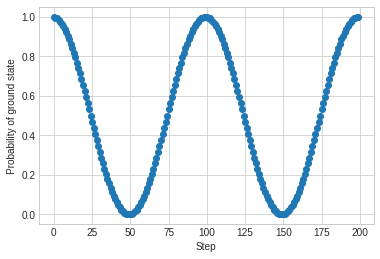

In [21]:
"""Plot the probability of measuring a qubit in the ground state."""
# Get a qubit.
a = cirq.NamedQubit('a')

# Get a circuit of a bunch of X rotations.
num_angles = 200
circuit = cirq.Circuit([cirq.Rx(rads=np.pi / 50.0)(a) for theta in range(num_angles)])

# List to store probabilities of the ground state.
probs = []

# Step through the simulation results.
for step in simulator.simulate_moment_steps(circuit):
    prob = np.abs(step.state_vector()) ** 2
    probs.append(prob[0])

# Plot the probability of the ground state at each simulation step.
plt.style.use('seaborn-whitegrid')
plt.plot(probs, 'o')
plt.xlabel("Step")
plt.ylabel("Probability of ground state");


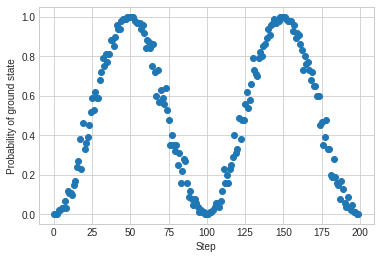

In [99]:
"""Plot the probability of measuring a qubit in the ground state by sampling."""
# Number of times to sample.
repetitions = 100

# List to store the probability of the ground state.
sampled_probs = []

for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    samples = step.sample([a], repetitions=repetitions)
    prob = np.sum(samples, axis=0)[0] / repetitions
    sampled_probs.append(prob)


# Plot the probability of the ground state at each simulation step.
plt.style.use('seaborn-whitegrid')
plt.plot(sampled_probs, 'o')
plt.xlabel("Step")
plt.ylabel("Probability of ground state");


In [100]:
"""Example of defining a custom gate in Cirq."""
class RationalGate(cirq.SingleQubitGate):

    def _unitary_(self):
        return np.array([[3 / 5, 4 / 5], [-4 / 5, 3 / 5]])

    def __str__(self):
        return 'ζ'


In [101]:
"""Using the custom gate in a circuit."""
a = cirq.NamedQubit('a')
rg = RationalGate()
print(cirq.Circuit(rg(a)))

a: ───ζ───


In [102]:
print(cirq.unitary(rg))


[[ 0.6  0.8]
 [-0.8  0.6]]


In [103]:
"""Simulate a circuit with a custom gate."""
circuit = cirq.Circuit(rg(a))
simulator = cirq.Simulator()
result = simulator.simulate(circuit)
print(result.final_state_vector)

[ 0.6+0.j -0.8+0.j]


In [118]:
#Ex 4
"""Define a custom controlled cirq.rx gate here."""
class CRx(cirq.TwoQubitGate):
    def __init__(self, theta):
        self.theta = theta

    def _unitary_(self):
        return np.array([[1, 0, 0, 0], [0, 1, 0, 0], 
                         [0, 0, math.cos(self.theta / 2) , -1j * math.sin(self.theta / 2)], 
                         [1, 0, -1j * math.sin(self.theta / 2), math.cos(self.theta / 2)]])

    def _circuit_diagram_info_(self, args):
        return '@', 'Rx({}π)'.format(self.theta / np.pi)

# Print out its unitary.
print(np.around(cirq.unitary(CRx(0.5 * np.pi)), 3))

[[1.   +0.j    0.   +0.j    0.   +0.j    0.   +0.j   ]
 [0.   +0.j    1.   +0.j    0.   +0.j    0.   +0.j   ]
 [0.   +0.j    0.   +0.j    0.707+0.j    0.   -0.707j]
 [1.   +0.j    0.   +0.j    0.   -0.707j 0.707+0.j   ]]


In [119]:
"""Display a circuit with the custom gate."""
# Get qubits.
a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')

# Display the circuit.
print('Circuit diagram:')
print(cirq.Circuit(CRx(0.25 * np.pi)(a, b)))

Circuit diagram:
a: ───@───────────
      │
b: ───Rx(0.25π)───


In [120]:
"""Example of a custom gate which supports the decompose protocol."""
class HXGate(cirq.SingleQubitGate):

    def _decompose_(self, qubits):
        return cirq.H(*qubits), cirq.X(*qubits)

    def __str__(self):
        return 'HX'
    
"""Use the gate in a circuit."""
HX = HXGate()

a = cirq.NamedQubit('a')
circuit = cirq.Circuit(HX(a))
print(circuit)

a: ───HX───


In [121]:
"""Decompose the gate."""
print(cirq.Circuit(cirq.decompose(circuit)))

a: ───Y^0.5───X───X───


In [122]:
"""Decompose the gate once."""
print(cirq.Circuit(cirq.decompose_once(HX(a))))

a: ───H───X───


In [123]:
"""Define a circuit with parameterized gates."""
# Import sympy for parameterized values.
import sympy as sp

# Get qubits to use in the circuit.
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

# Define a parameterized value.
val = sp.Symbol("s")

# Create a circuit.
circuit = cirq.Circuit(cirq.X.on(a) ** val, cirq.X.on(b) ** val)

# Display it.
print("Circuit with parameterized gates:\n")
print(circuit)

Circuit with parameterized gates:

a: ───X^s───

b: ───X^s───


In [124]:
"""Simulate the circuit at multiple parameter values."""
simulator = cirq.Simulator()

# Simulate the circuit for several values of the parameter.
num_params = 5
for y in range(num_params):
    result = simulator.simulate(circuit, param_resolver={"s": y / 4.0})
    print("s={}: {}\n".format(y, np.around(result.final_state_vector, 2)))

s=0: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]

s=1: [ 0.6 +0.6j   0.25-0.25j  0.25-0.25j -0.1 -0.1j ]

s=2: [0. +0.5j 0.5+0.j  0.5+0.j  0. -0.5j]

s=3: [-0.1 +0.1j   0.25+0.25j  0.25+0.25j  0.6 -0.6j ]

s=4: [0.+0.j 0.+0.j 0.+0.j 1.+0.j]



In [125]:
"""Simulate the circuit at multiple parameter values."""
# Get a list of param resolvers.
num_params = 5
resolvers = [cirq.ParamResolver({'s': y / 8.0}) for y in range(num_params)]

# Add measurements to the circuit.
circuit.append([cirq.measure(a), cirq.measure(b)])

# Simulate the circuit using run_sweep.
results = simulator.run_sweep(
    program=circuit,
    params=resolvers,
    repetitions=10
)

for i, result in enumerate(results):
    print('params: {}\n{}\n'.format(result.params.param_dict, result))

params: OrderedDict([('s', 0.0)])
a=0000000000
b=0000000000

params: OrderedDict([('s', 0.125)])
a=0000000100
b=0000000000

params: OrderedDict([('s', 0.25)])
a=0001000000
b=0100000000

params: OrderedDict([('s', 0.375)])
a=1101100010
b=1001000010

params: OrderedDict([('s', 0.5)])
a=0101110111
b=1010100101



<AxesSubplot:xlabel='theta'>

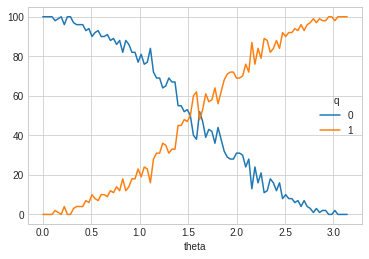

In [133]:
'''
import pandas
q = cirq.NamedQubit("q")
theta = sp.Symbol("theta")
parameterized_circuit = cirq.Circuit(
    # your code here
    cirq.X.on(q) ** theta
    cirq.measure(q)
)
# replace None with something else

resolvers = [cirq.ParamResolver({'s': t / 100}) for t in range(100)]

param_resolvers = None
repetitions = 100
results = cirq.Simulator().sample(
    program=parameterized_circuit,
    params=param_resolvers,
    repetitions=repetitions
)

# You can test with the following plot
# pandas.crosstab(results.theta, results.q).plot()'''
import pandas
q = cirq.NamedQubit("q")
parameterized_circuit = cirq.Circuit([cirq.Rx(rads=sp.Symbol("theta"))(q), cirq.measure(q)])
param_resolvers = cirq.Linspace(start=0, stop=np.pi, length=100, key='theta')
results = cirq.Simulator().sample(
    program=parameterized_circuit,
    params=param_resolvers,
    repetitions=repetitions
)
pandas.crosstab(results.theta, results.q).plot()


In [134]:
class CXOptimizer(cirq.PointOptimizer):
    """Replaces a CX surrounded by Hadamards

        Note: This implementation does not generalize for all situations. It is
        a simplified version which works for the trivial case where Hs, CX, Hs
        are present in consecutive moments, as given in the sample input.
    """

    def optimization_at(self, circuit, index, op):
        if isinstance(op, cirq.GateOperation) and (op.gate == cirq.H):
            q0, = op.qubits
            next_op = circuit.operation_at(q0, index + 1)
            if isinstance(next_op, cirq.GateOperation) and next_op.gate == cirq.CX:
                qubits = circuit.operation_at(q0, index + 1).qubits
                if all(
                    circuit.operation_at(q, idx).gate == cirq.H
                    for idx in [index, index + 2]
                    for q in qubits
                ):
                    return cirq.PointOptimizationSummary(
                        clear_span = 3,
                        clear_qubits = qubits,
                        new_operations = [cirq.CX(qubits[1], qubits[0])]
                    )

opt = CXOptimizer()
circuit = cirq.Circuit(
    cirq.H.on_each(a, b, c), 
    cirq.CNOT(a, b), 
    cirq.H.on_each(a, b), 
    cirq.CZ(a, b)
)
print("Before optimizing:\n{}\n". format(circuit))
opt.optimize_circuit(circuit)
print("After optimizing:\n{}".format(circuit))


Before optimizing:
a: ───H───@───H───@───
          │       │
b: ───H───X───H───@───

c: ───H───────────────

After optimizing:
a: ───X───────────@───
      │           │
b: ───@───────────@───

c: ───H───────────────
